In [6]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 

from utils import *

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:
# load preprocessed amazon review dataset from directory
data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/preprocessed_news.csv", nrows=100000)
print('전체 샘플수 :', (len(data)))
data.sample(20)

전체 샘플수 : 98360


,headlines,text
23309,congress complain rs chairman rs chairman,congress party rajya sabha members assam plann...
84887,video shows two men thrashing mentally challen...,video showing two men thrashing mentally chall...
42419,astronauts need two thousand seven hundred thr...,american heart association said astronauts nee...
70605,smart parking platform get parking raises doll...,delhi based smart parking startup get parking ...
93223,married couple trying conceive discover twins,married couple mississippi us recently discove...
4930,turkish prez man eradicate isis syria trump,us president donald trump said turkish preside...
7918,john abraham surprises acid attack survivors l...,john abraham surprised group acid attack survi...
32316,defending champs mi register seventh consecuti...,defending champions mumbai indians registered ...
3611,ninety four one hundred twenty nine airports m...,one hundred twenty nine airports owned managed...
45649,unilever ceo paul polman pay rose fifty one pe...,consumer goods giant unilever ceo paul polman ...


### 데이터 전처리

##### 1) train / test split

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 95
텍스트의 평균 길이 : 38.582035380235865
요약문의 최소 길이 : 1
요약문의 최대 길이 : 23
요약문의 평균 길이 : 7.899339162261081


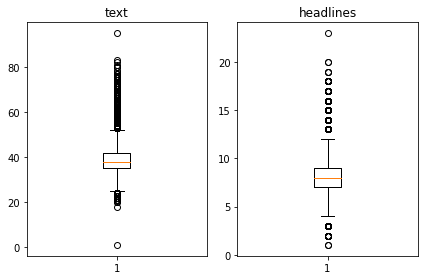

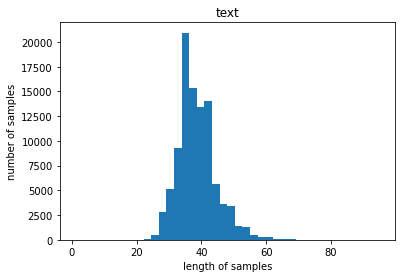

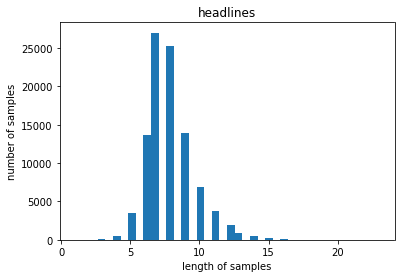

In [16]:
# 샘플의 텍스트/요약문 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
summary_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약문의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약문의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약문의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [17]:
# mean + 2*std를 텍스트 길이의 상한선으로 설정 -> 손실되는 text 5% 미만
text_max_len = int(np.mean(text_len) + 2 * np.std(text_len))
print(text_max_len)

summary_max_len = int(np.mean(summary_len) + 2 * np.std(summary_len))
print(summary_max_len)

50
11


In [18]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 50 이하인 샘플의 비율: 0.9583367222448149
전체 샘플 중 길이가 11 이하인 샘플의 비율: 0.9613359089060594


In [19]:
data = data[(data["text"].apply(lambda x: len(x.split()) <= text_max_len)) & 
(data["headlines"].apply(lambda x: len(x.split()) <= summary_max_len))]

print('전체 샘플수 :', (len(data)))

전체 샘플수 : 91643


In [20]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches career ml al ninety pe...,saurav kant alumnus upgrad iit pg program mach...,sostoken upgrad learner switches career ml al ...,upgrad learner switches career ml al ninety pe...
1,delhi techie wins free food swiggy one year cred,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food swiggy on...,delhi techie wins free food swiggy one year cr...
2,new zealand end rohit sharma led india twelve ...,new zealand defeated india eight wickets fourt...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india twelve ...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,known hirani yrs metoo claims true sonam,speaking sexual harassment allegations rajkuma...,sostoken known hirani yrs metoo claims true sonam,known hirani yrs metoo claims true sonam eostoken


In [21]:
# numpy array로 저장
encoder_input = np.array(data['text']) 
decoder_input = np.array(data['decoder_input']) 
decoder_target = np.array(data['decoder_target']) 

In [22]:
en_x_train, en_x_test, de_x_train, de_x_test, de_y_train, de_y_test = train_test_split(
    encoder_input, decoder_input, decoder_target, test_size=0.2)

In [23]:
print('훈련 데이터의 개수 :', len(en_x_train))
print('훈련 레이블의 개수 :', len(de_x_train))
print('테스트 데이터의 개수 :', len(en_x_test))
print('테스트 레이블의 개수 :', len(de_x_test))

훈련 데이터의 개수 : 73314
훈련 레이블의 개수 : 73314
테스트 데이터의 개수 : 18329
테스트 레이블의 개수 : 18329


##### 2) 정수 인코딩

In [24]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(en_x_train)

In [25]:
threshold = 9
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 68269
등장 빈도가 8번 이하인 희귀 단어의 수: 49378
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 18891
단어 집합에서 희귀 단어의 비율: 72.32858251915218
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.146139655670809


In [26]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20000으로 제한
src_tokenizer.fit_on_texts(en_x_train) # 단어 집합 재생성

In [27]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
en_x_train_tk = src_tokenizer.texts_to_sequences(en_x_train) 
en_x_test_tk = src_tokenizer.texts_to_sequences(en_x_test)

# 잘 진행되었는지 샘플 출력
print(en_x_train_tk[:3])

[[1760, 12164, 10902, 536, 40, 126, 1271, 4130, 34, 174, 1, 1418, 39, 2421, 11171, 12911, 3448, 6, 46, 331, 1271, 174, 1979, 8849, 1751, 2945, 55], [102, 405, 67, 87, 346, 803, 44, 23, 192, 145, 248, 64, 124, 59, 47, 56, 64, 80, 506, 21, 1357, 18892, 1, 397, 12912, 7742, 17865, 44, 67, 7291, 3792, 7742, 1395], [711, 16180, 100, 30, 1079, 268, 8850, 1187, 2862, 11172, 3039, 2035, 602, 746, 10384, 229, 641, 68, 1, 14, 308, 14888, 5391, 3385, 71, 264, 93, 665, 490, 398, 14888, 2074, 2223, 1134, 1020]]


In [28]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(de_x_train)

In [29]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 29805
등장 빈도가 5번 이하인 희귀 단어의 수: 19683
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10122
단어 집합에서 희귀 단어의 비율: 66.03925515853045
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 5.89452206194916


In [30]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(de_x_train)
tar_tokenizer.fit_on_texts(de_y_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
de_x_train_tk = tar_tokenizer.texts_to_sequences(de_x_train) 
de_y_train_tk = tar_tokenizer.texts_to_sequences(de_y_train)
de_x_test_tk = tar_tokenizer.texts_to_sequences(de_x_test)
de_y_test_tk = tar_tokenizer.texts_to_sequences(de_y_test)

# 잘 변환되었는지 확인
print('decoder input: ', de_x_train_tk[:5])
print('decoder target: ', de_y_train_tk[:5])

decoder input:  [[1, 2873, 1275, 3450, 148, 8533], [1, 7422, 737, 368, 52, 12, 4143, 658, 25, 392], [1, 590, 85, 465, 759], [1, 891, 5590, 106, 190, 258], [1, 91, 1218, 789, 393, 190, 751, 630]]
decoder target:  [[2873, 1275, 3450, 148, 8533, 2], [7422, 737, 368, 52, 12, 4143, 658, 25, 392, 2], [590, 85, 465, 759, 2], [891, 5590, 106, 190, 258, 2], [91, 1218, 789, 393, 190, 751, 630, 2]]


In [31]:
drop_train = [index for index, sentence in enumerate(de_x_train_tk) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(de_x_test_tk) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

en_x_train_tk = [sentence for index, sentence in enumerate(en_x_train_tk) if index not in drop_train]
de_x_train_tk = [sentence for index, sentence in enumerate(de_x_train_tk) if index not in drop_train]
de_y_train_tk = [sentence for index, sentence in enumerate(de_y_train_tk) if index not in drop_train]

en_x_test_tk = [sentence for index, sentence in enumerate(en_x_test_tk) if index not in drop_test]
de_x_test_tk = [sentence for index, sentence in enumerate(de_x_test_tk) if index not in drop_test]
de_y_test_tk = [sentence for index, sentence in enumerate(de_y_test_tk) if index not in drop_test]

print('훈련 데이터의 개수 :', len(en_x_train))
print('훈련 레이블의 개수 :', len(de_x_train))
print('테스트 데이터의 개수 :', len(en_x_test))
print('테스트 레이블의 개수 :', len(de_x_test))

삭제할 훈련 데이터의 개수 : 2
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 73314
훈련 레이블의 개수 : 73314
테스트 데이터의 개수 : 18329
테스트 레이블의 개수 : 18329


In [32]:
en_x_train_tk = pad_sequences(en_x_train_tk, maxlen=text_max_len, padding='post')
en_x_test_tk = pad_sequences(en_x_test_tk, maxlen=text_max_len, padding='post')
de_x_train_tk = pad_sequences(de_x_train_tk, maxlen=summary_max_len, padding='post')
de_x_test_tk = pad_sequences(de_x_test_tk, maxlen=summary_max_len, padding='post')
de_y_train_tk = pad_sequences(de_y_train_tk, maxlen=summary_max_len, padding='post')
de_y_test_tk = pad_sequences(de_y_test_tk, maxlen=summary_max_len, padding='post')

### 모델 설계

In [33]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

##### Encoder

In [34]:
embedding_dim = 256
hidden_size = 512

# 인코더 input
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output3, state_h3, state_c3 = encoder_lstm3(encoder_output2)

##### Decoder

In [35]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [36]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 256)      5120000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 512), (N 1574912     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [37]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_output3])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 256)      5120000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 512), (N 1574912     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

### training & test

##### training

In [38]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=1, verbose=1)
history = model.fit(x=[en_x_train_tk, de_x_train_tk], y=de_y_train_tk, \
          validation_data=([en_x_test_tk, de_x_test_tk], de_y_test_tk), \
          batch_size=512, callbacks=[es], epochs=50)

Epoch 1/50
144/144 [==============================] - 74s 465ms/step - loss: 5.6433 - val_loss: 5.2231
Epoch 2/50
144/144 [==============================] - 72s 498ms/step - loss: 5.2305 - val_loss: 5.0927
Epoch 3/50
144/144 [==============================] - 72s 500ms/step - loss: 5.0723 - val_loss: 4.9428
Epoch 4/50
144/144 [==============================] - 72s 503ms/step - loss: 4.8889 - val_loss: 4.7862
Epoch 5/50
144/144 [==============================] - 73s 504ms/step - loss: 4.6934 - val_loss: 4.6119
Epoch 6/50
144/144 [==============================] - 73s 505ms/step - loss: 4.4973 - val_loss: 4.4745
Epoch 7/50
144/144 [==============================] - 73s 505ms/step - loss: 4.2980 - val_loss: 4.3417
Epoch 8/50
144/144 [==============================] - 73s 506ms/step - loss: 4.1091 - val_loss: 4.2040
Epoch 9/50
144/144 [==============================] - 73s 505ms/step - loss: 3.9133 - val_loss: 4.0858
Epoch 10/50
144/144 [==============================] - 73s 505ms/step - l

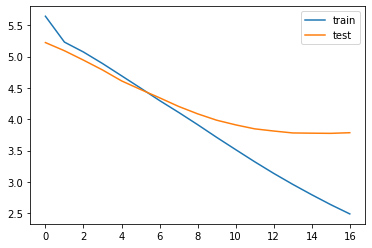

In [39]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

##### inference

In [40]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어

inference model design

In [41]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [42]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [43]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [44]:
for i in range(50):
    print("원문 :", seq2text(en_x_test_tk[i], src_index_to_word))
    print("실제 요약 :", seq2summary(de_x_test_tk[i], tar_word_to_index, tar_index_to_word))
    print("예측 요약 :", decode_sequence(en_x_test_tk[i].reshape(1, text_max_len)))
    print("\n")

원문 : world health organisation warned nearly two hundred crore people worldwide currently use water contaminated faeces un agency said dramatic improvements needed ensuring global access clean water sanitation contaminated drinking water estimated cause five lakh deaths year maria head public health department said 
실제 요약 : two hundred crore people drinking contaminated water 
예측 요약 :  indians get one hundred percents citizens leave india report


원문 : sachin tendulkar friday shared twitter handwritten letter one fans kerala fan compared tendulkar batting poem written cricket bat thank much letter fans like inspired keep better better tendulkar captioned post 
실제 요약 : tendulkar shares handwritten letter fan twitter 
예측 요약 :  sachin tendulkar attends pace cricket


원문 : railways officials said received good morning good evening messages complaints whatsapp helpline numbers launched helpline numbers passengers lodge complaints lack cleanliness stations official said also received hindi p

예측 요약 :  jandk govt identifies tenl compensation jawans martyred areas


원문 : ajay devgn starrer golmaal become actor highest grossing film earnings one hundred forty three point thirty three crore surpassed lifetime earnings devgn two thousand fourteen film returns earned one hundred forty point sixty two crore golmaal also second highest hindi grosser two thousand seventeen hindi version baahubali conclusion 
실제 요약 : golmaal becomes ajay devgn highest grossing film 
예측 요약 :  dangal becomes first film earn one hundred crore club


원문 : us international community going run scared north korea us ambassador nikki haley said reclusive state refused roll back nuclear ballistic missile programme north korea reportedly said launch thousand fold revenge us imposing punitive sanctions nuclear programme un 
실제 요약 : going run scared north korea us 
예측 요약 :  us korea conduct korea talks


원문 : indian premier league side rajasthan royals begun go green initiative side help plant one million saplin

예측 요약 :  wb governor calls nrc nrc


원문 : talking recent concerns rising pollution delhi ncr west bengal cm mamata banerjee suggested capital political pollution causing much air pollution pointing sri lankan cricketers wear masks playing test match feroz shah kotla banerjee said political pollution weather pollution delhi represents 
실제 요약 : delhi political pollution causing air pollution mamata 
예측 요약 :  mamata banerjee meets bengal cm mamata banerjee


원문 : vancouver captain chris gayle pulled one handed catch right hand almost dropped catch left hand global ttwenty canada final sunday west indies hodge edged fawad ahmed delivery towards slips gayle completed catch cannot commentator screamed 
실제 요약 : gayle almost drops catch left hand takes right 
예측 요약 :  stokes scores four sixes one hundredth catch


원문 : us president donald trump said greatest assets mental stability like really smart comes book claimed several aides considered unfit office went successful businessman president 

### 추출적 요약 결과와 비교해보기(with 매트릭스 시놉시스 데이터셋)

In [45]:
import requests
from summa.summarizer import summarize

In [46]:
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text
print(text[:1500])

The screen is filled with green, cascading code which gives way to the title, The Matrix.

A phone rings and text appears on the screen: "Call trans opt: received. 2-19-98 13:24:18 REC: Log>" As a conversation takes place between Trinity (Carrie-Anne Moss) and Cypher (Joe Pantoliano), two free humans, a table of random green numbers are being scanned and individual numbers selected, creating a series of digits not unlike an ordinary phone number, as if a code is being deciphered or a call is being traced.

Trinity discusses some unknown person. Cypher taunts Trinity, suggesting she enjoys watching him. Trinity counters that "Morpheus (Laurence Fishburne) says he may be 'the One'," just as the sound of a number being selected alerts Trinity that someone may be tracing their call. She ends the call.

Armed policemen move down a darkened, decrepit hallway in the Heart O' the City Hotel, their flashlight beam bouncing just ahead of them. They come to room 303, kick down the door and find a

In [47]:
# 전체 문장의 0.5%만 요약문으로 추출
print('Summary:', summarize(text, ratio=0.005))

Summary: Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


In [48]:
# 요약문에 포함된 단어 수를 50개로 제한
print(summarize(text, words=50))

Trinity takes Neo to Morpheus.
Morpheus, Trinity, Neo, Apoc, Switch, Mouse and Cypher are jacked into the Matrix.
Trinity brings the helicopter down to the floor that Morpheus is on and Neo opens fire on the three Agents.


- **추출적 요약**: 원본 문장에서 중요한 문장을 직접 가져오기 때문에 문장 내부적으로 문법의 오류가 없다. 하지만 핵심 개념이 중복될 수 있으며, 중요한 단어가 포함되지만 문맥이 부자연스러울 수도 있다.
- **추상적 요약**: 새로운 문장을 생성하여 더 압축적인 요약이 가능하며, 문맥이 상대적으로 매끄럽다. 하지만 문법적으로 부자연스럽거나, 원본 문장에서 사용된 특정한 핵심 단어가 포함되지 않을 가능성이 있다.

### Done

1. 데이터 전처리 함수
- 수치 데이터와 일부 특수기호도 중요한 정보인데 이것도 없애야 할까?
    - $ → ‘dollar’, % → ‘percent’, & → ‘and’로 변경하는 로직 추가
    - num2words 라이브러리로 숫자를 문자로 변경 (ex : 2000 → two thousands)
    - 숫자 사이에 콤마나 점이 있는 경우에 대응
        - 1.5를 one point five로 읽도록 수정
        - 1,000을 one zero로 읽는 문제 해결
- `sentence = re.sub("[m]{2,}", "mm", sentence)` → 다른 알파벳도 3개 이상 반복되면 2개로 바꾸는 로직 추가
- 'iso-8859-1’ 인코딩에 글씨 깨짐이 발생하는 경우가 있어 ‘utf-8’로 변경

### To-do

1. 하이퍼파라미터 튜닝 with keras tuner
    - embedding_dim
    - hidden_size
    - dropout
    - layer 개수
    - learning rate  
<br/><br/>
2. 어텐션 메커니즘
    - Luong attention 분석
    - Bahdanau 모델 구현 & 성능 비교